In [11]:
import numpy as np
from qiskit import *
from qiskit.tools.visualization import plot_histogram

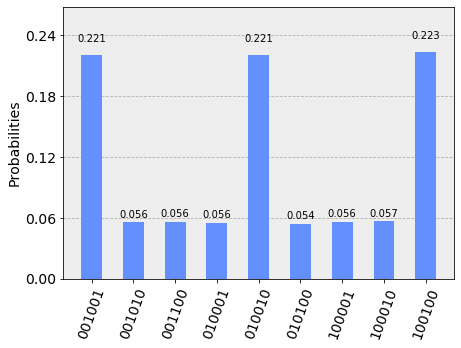

In [152]:
def setEqualProbabilities(circuit, quantumRegister):
    #circuit.initialize([0, 1/np.sqrt(3), 1/np.sqrt(3), 0, 1/np.sqrt(3), 0, 0, 0 ], range(3))
    q = quantumRegister
    rot = 2* np.arcsin(1/np.sqrt(3))
    circuit.ry(rot, q[0])

    circuit.x(q[0])
    circuit.ch(q[0], q[1])
    
    circuit.x(q[1])
    circuit.ccx(q[0], q[1], q[2])
    circuit.x(q[1])
    
    circuit.x(q[0])

def chooseDoorToOpen(circuit, doors, choices, monty):
    
    def cch(circuit, control0, control1, target):
        circuit.ry(np.pi/4, target)
        circuit.ccx(control0, control1, target)
        circuit.ry(-np.pi/4, target)
    
    cch(circuit, doors[0], choices[0], monty[0])
    circuit.ccx(doors[0], choices[1], monty[0])
    
    cch(circuit, doors[1], choices[1], monty[0])
    circuit.ccx(doors[1], choices[2], monty[0])
    
    circuit.ccx(doors[2], choices[0], monty[0])
    cch(circuit, doors[2], choices[2], monty[0])
    
def shift(circuit, quantumRegister):
    circuit.swap(quantumRegister[0], quantumRegister[2])
    circuit.swap(quantumRegister[2], quantumRegister[1])

def cshift(control, circuit, quantumRegister):
    circuit.cswap(control, quantumRegister[0], quantumRegister[2])
    circuit.cswap(control, quantumRegister[2], quantumRegister[1])
    
doors = QuantumRegister(3)
choices = QuantumRegister(3)
monty = QuantumRegister(1)
c = ClassicalRegister(6)

circuit = QuantumCircuit(doors, choices, monty,c)

setEqualProbabilities(circuit, doors)
setEqualProbabilities(circuit, choices)

chooseDoorToOpen(circuit, doors, choices, monty)

shift(circuit, choices)
cshift(monty[0], circuit, choices)

circuit.measure(range(6), range(6))
circuit.draw()

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, localSimulator, shots=100000).result()
counts = result.get_counts(circuit)
plot_histogram(counts)

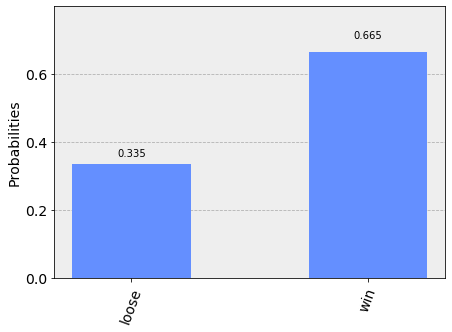

In [153]:
def validateCounts(counts):
    stats = {'win':0, 'loose':0}
    for key in counts:
        doorString = key[0:3]
        choiceString = key[3:]
        
        door = doorString.find('1')
        if (door == -1):
            raise ValueError('No winning door')
        if (doorString.find('1', door+1) != -1):
            raise ValueError('More than one winning door')
        
        choice = choiceString.find('1')
        if (choice == -1):
            raise ValueError('No choice')
        if (choiceString.find('1', choice+1) != -1):
            raise ValueError('More than one choice')
            
        if (door == choice):
            stats['win'] += counts[key]
        else:
            stats['loose'] += counts[key]
            
    return stats

simulationResult = validateCounts(counts)
plot_histogram(simulationResult)